In [5]:
%cd /home/novelli/encoderops

/home/novelli/encoderops


In [33]:
import treescope
import torch
from dotenv import load_dotenv
from pathlib import Path
from src.model import EvolutionOperator
from src.data import DESRESDataset
from src.configs import ModelArgs # noqa
from torch.utils.data import RandomSampler
from torch_geometric.loader import DataLoader
from loguru import logger
from dataclasses import asdict
import linear_operator_learning as lol
import matplotlib.pyplot as plt
from src.data import mdtraj_load
import numpy as np
import os
from analysis.descriptors import compute_descriptors
load_dotenv()

#treescope.basic_interactive_setup()


def deterministic_sampler(dataset, subsample:float, seed: int, verbose: bool = True):
    generator = torch.Generator()
    generator.manual_seed(seed)
    num_samples = int(len(dataset)*subsample)
    if verbose:
        logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
    sampler = RandomSampler(dataset, num_samples=num_samples, generator=generator)
    return sampler


def load_run(run_id: str, protein_id: str, traj_id:int = 0, epoch: int | None = None, progress: bool = True, subsample: float | None = None):
    reg=1e-4
    rng_seed = 42
    batch_size = 1024
    data_path = Path(f"logs/encoderops-{protein_id}-{traj_id}/{run_id}")
    if epoch is None:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob("**/last.ckpt")))
    else:
        model = EvolutionOperator.load_from_checkpoint(next(data_path.glob(f"**/epoch={epoch}*.ckpt")))
    dataset = DESRESDataset(model.data_args.protein_id, lagtime=model.data_args.lagtime)
    embeddings = {"t": [], "lag": []}
    model = model.eval()
    if subsample is not None:
        num_samples = int(len(dataset)*subsample)
        logger.info(f"Subsampling {num_samples} samples ({num_samples/len(dataset):.3f}%)")
        sample_idxs = [idx for idx in deterministic_sampler(dataset, subsample, rng_seed, verbose=False)]
        sampler = deterministic_sampler(dataset, subsample, rng_seed)
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        dataloader = DataLoader(
            dataset, batch_size=batch_size, shuffle=False
        )
        sample_idxs = None

    with torch.no_grad():
        if progress:
            from tqdm.auto import tqdm
            dataloader = tqdm(dataloader)
        for batch in dataloader:
            for k, v in batch.items():
                batch[k] = v.to(model.device)
            # data
            x_t = model._setup_graph_data(batch)
            x_lag = model._setup_graph_data(batch, key="item_lag")
            # forward
            f_t = model.forward_nn(x_t)
            f_lag = model.forward_nn(x_lag)
            embeddings["t"].append((f_t.detach().cpu()))
            embeddings["lag"].append((f_lag.detach().cpu()))
    phi_t = torch.cat(embeddings["t"])
    phi_lag = torch.cat(embeddings["lag"])
    logger.info(f"model mean {model.f_mean}\nstat mean {phi_t.mean(dim=0)}\n diff {model.f_mean.to('cpu') - phi_t.mean(dim=0)}")
    cov_X = model.cov.to('cpu')
    cov_X += torch.eye(cov_X.shape[0], device=cov_X.device) * reg
    cov_XY = model.cross_cov.to('cpu')
    G = torch.linalg.solve(cov_X, cov_XY)
    l, Q = torch.linalg.eig(G) # Q @ torch.diag(l) @ Q^-1 = G
    sort_perm = torch.argsort(l.abs(), descending=True)
    l = l[sort_perm]
    Q = Q[:, sort_perm]
    r_fun = phi_t.to(dtype=Q.dtype) @ Q 
    results = {
        "embedding_t": phi_t,
        "embedding_lag": phi_lag,
        "eigenvalues": l,
        "eigenvectors": Q,
        "r_fun": r_fun,
        "sample_idxs": sample_idxs
    }
    return model, results

def descriptors(protein_id: str, sample_idxs: list[int] | None, descriptors=['dihedrals'], traj_id:int = 0, ):
    protein_path = Path(os.environ["DATA_PATH"]) / f"DESRES-Trajectory_{protein_id}-{traj_id}-protein/{protein_id}-{traj_id}-protein"
    trajectory_files = [str(traj) for traj in protein_path.glob("*.dcd")]
    top = next(protein_path.glob("*.pdb")).__str__()
    traj = mdtraj_load(trajectory_files, top, 1)
    if sample_idxs:
        traj = traj[sample_idxs]
    descriptors_df, feats_info = compute_descriptors(traj, descriptors)
    return traj, descriptors_df, feats_info

In [57]:
protein_id = "CLN025"

run_id = "uuaz2hv8"
subsample = 0.04

model, results = load_run(run_id, protein_id, subsample=subsample)

2025-05-05 17:54:51.327 | INFO     | __main__:load_run:47 - Subsampling 21389 samples (0.040%)
2025-05-05 17:54:51.358 | INFO     | __main__:deterministic_sampler:28 - Subsampling 21389 samples (0.040%)
100%|██████████| 21/21 [01:44<00:00,  4.99s/it]
2025-05-05 17:56:36.231 | INFO     | __main__:load_run:74 - model mean tensor([0.4967, 0.5033, 0.5198, 0.4802, 0.5240, 0.4760, 0.5076, 0.4924, 0.4588,
        0.5412, 0.5192, 0.4808, 0.5412, 0.4588, 0.4890, 0.5110, 0.5085, 0.4915,
        0.5166, 0.4834, 0.5203, 0.4797, 0.5216, 0.4784, 0.5288, 0.4712, 0.4894,
        0.5106, 0.5162, 0.4838, 0.5197, 0.4803, 0.4781, 0.5219, 0.4980, 0.5020,
        0.5057, 0.4943, 0.4964, 0.5036, 0.5007, 0.4993, 0.4732, 0.5268, 0.5176,
        0.4824, 0.4827, 0.5173, 0.4714, 0.5286, 0.5064, 0.4936, 0.5234, 0.4766,
        0.4842, 0.5158, 0.4771, 0.5229, 0.4570, 0.5430, 0.4901, 0.5099, 0.5040,
        0.4960], device='cuda:0')
stat mean tensor([0.4942, 0.5058, 0.4900, 0.5100, 0.5237, 0.4763, 0.5217, 0.4783, 0.

In [58]:
traj, desc_df, feats_info = descriptors(protein_id, sample_idxs=results['sample_idxs'], descriptors=['dihedrals'])

Text(0, 0.5, 'Distribution')

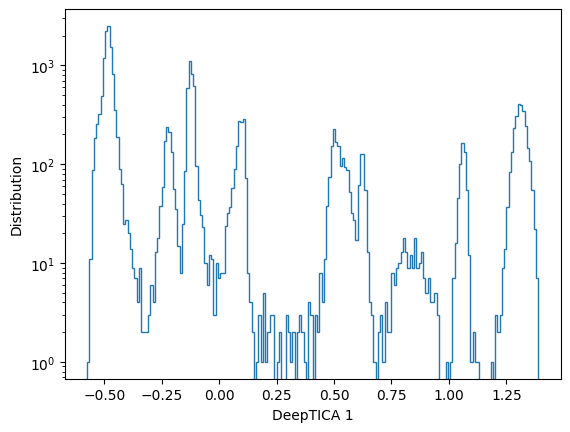

In [59]:
fig, ax = plt.subplots()
eigfun = results['r_fun'][:, 1].real
ax.hist(eigfun,bins=200,histtype='step')
ax.set_yscale('log')
ax.set_xlabel('DeepTICA 1')
ax.set_ylabel('Distribution')

In [120]:
from mlcolvar.data import DictDataset
df = desc_df.copy()
labels = np.zeros(len(df))
# State 1
labels[np.argwhere(eigfun < 0.25)] = 1
# State 2
mask = np.logical_and(eigfun < 1.0, eigfun > 0.25)
labels[np.argwhere(mask)] = 2
# State 3
labels[np.argwhere(eigfun > 1.0)] = 3


df['labels'] = labels
sel = (df['labels'] != 0 )

descr_type = 'angles' #'distances' #'angles' 
stride = 10

if descr_type == 'angles':
    # get descriptors
    X = df[sel].filter(regex='phi|psi|xi|theta').values[::stride]
    feat_names = df[sel].filter(regex='phi|psi|xi|theta').columns.values

    # get labels
    y = df[sel]['labels'][::stride]

elif descr_type == 'distances':
    # get descriptors
    X = df[sel].filter(regex='DIST').values[::stride]
    feat_names = df[sel].filter(regex='DIST').columns.values

    # get labels
    y = df[sel]['labels'][::stride]

# create dataset
dataset = DictDataset(dict(data=X,labels=y))
dataset.feature_names = feat_names
dataset

DictDataset( "data": [2139, 54], "labels": [2139], "data_type": descriptors )

In [121]:
from mlcolvar.explain.lasso import SparsityScoring, plot_lasso_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel

In [ ]:
def lasso_classification(dataset,
                         min_features = 0,
                         Cs = 40,
                         scale_inputs = True,
                         feature_names = None,
                         print_info = True,
                         plot = True
):
    """Perform sparse classification via LASSO on a given DictDataset (requires keys: "data" and "labels").
    The (inverse) regularization strength C is automatically chosen based on cross-validation on a set of values (Cs),
    see sklearn.linear_model.LogisticRegressionCV. The scoring function used is `SparsityScoring`, balancing the accuracy and the number of features.

    In the two-classes case a single classifier is built, otherwise a one-vs-rest classifier is constructed, composed by N different estimators are trained to classify each state from the others.
    
    Parameters
    ----------
    dataset : DictDataset
        dataset with 'data' and 'labels'
    min_features : int, optional
        minimum number of features, by default 0
    Cs : int or array-like, optional
        Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization., by default 40
    scale_inputs : bool, optional
        whether to standardize inputs based on mean and std.dev., by default True
    feature_names : list, optional
        names of the input features, if not given they are taken from `dataset.feature_names`, by default None
    print_info : bool, optional
        whether to print results, by default True
    plot : bool, optional
        whether to plot results, by default True

    See also
    --------
    mlcolvar.explain.lasso.SparsityScoring
        Scoring function used in LASSO classification

    Returns
    -------
    classifier: 
        optimized estimator
    feats: 
        dictionary with the names of the non-zero features, per label
    coeffs: 
        dictionary with the coefficients of the non-zero features, per label
    """

    # Convert dataset to numpy
    with torch.no_grad():
        raw_descriptors = dataset['data'].numpy()
        labels = dataset['labels'].numpy().astype(int)
    if feature_names is None:
        if dataset.feature_names is None:
            raise ValueError('Feature names not found (either in the dataset or as argument to the function).')
        feature_names = dataset.feature_names
    
    # Scaling inputs
    if scale_inputs:
        scaler = StandardScaler(with_mean=True, with_std=True)
        descriptors = scaler.fit_transform(raw_descriptors)
    else:
        descriptors = raw_descriptors

    # Define cross-validation for LASSO, using
    #   a custom scoring function based on accuracy and number of features
    scorer = SparsityScoring(min_features=min_features) 

    _classifier = LogisticRegressionCV(Cs=Cs, 
                                    solver='liblinear', 
                                    multi_class='ovr', 
                                    fit_intercept=False, 
                                    penalty='l1',
                                    n_jobs=20, 
                                    max_iter = 200,
                                    scoring=scorer)

    # Fit classifier
    feature_selector = SelectFromModel(_classifier)
    feature_selector.fit(descriptors, labels)

    classifier = feature_selector.estimator_

    # Get selected features and coefficients 
    feats = {}
    coeffs = {}

    for i,key in enumerate(classifier.coefs_paths_.keys()):

        index = np.abs(classifier.coef_).argsort()[i][::-1]

        sorted_feature_names = feature_names[index]
        sorted_coeffs = classifier.coef_[i,index]

        idx = np.argwhere ( np.abs(sorted_coeffs)>1e-5 )[:,0]
        selected_feature_names = sorted_feature_names[idx]
        selected_coeffs = sorted_coeffs[idx] 
        feats[key] = selected_feature_names
        coeffs[key] = selected_coeffs

        # display summary
        if print_info:
            #score = classifier.score(descriptors,labels)
            C_idx = np.argwhere(np.abs(classifier.Cs_ - classifier.C_[i]) < 1e-8)[0,0]
            score = classifier.scores_[key].mean(axis=0)[C_idx]
            accuracy = classifier.scoring.accuracy_from_score(score, len(selected_coeffs))

            print(f'======= LASSO results ({key}) ========')
            print(f'- Regularization : {classifier.C_[i]:.8f}')
            print(f'- Score          : {score:.2f}')
            print(f'- Accuracy       : {accuracy*100:.2f}%')
            print(f'- # features     : {len(selected_coeffs)}\n')
            print('Features: ')
            for j,(f,c) in enumerate(zip(selected_feature_names, selected_coeffs)):
                print(f'({j+1}) {f:13s}: {c:.6f}')
            print('==================================\n')

    # plot results
    if plot:
        plot_lasso_classification(classifier, feats, coeffs)

    return classifier, feats, coeffs

/home/novelli/encoderops/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/novelli/encoderops/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


======= LASSO results (1) ========
- Regularization : 0.00599484
- Score          : -29.01
- Accuracy       : 74.99%
- # features     : 4

Features: 
(1) cos_phi GLY7 : 0.411382
(2) sin_psi THR6 : 0.239758
(3) sin_phi GLY7 : -0.062738
(4) cos_psi THR8 : 0.000846

======= LASSO results (2) ========
- Regularization : 0.04641589
- Score          : -47.26
- Accuracy       : 69.74%
- # features     : 17

Features: 
(1) sin_psi THR6 : -0.110109
(2) cos_phi PRO4 : -0.077407
(3) cos_psi ASP3 : 0.075421
(4) cos_phi GLU5 : 0.062542
(5) sin_psi THR8 : 0.061667
(6) sin_phi GLY7 : -0.057473
(7) sin_psi PRO4 : -0.049664
(8) cos_psi GLU5 : 0.034835
(9) cos_psi TRP9 : 0.032442
(10) cos_phi THR6 : -0.031445
(11) sin_psi TRP9 : -0.024770
(12) sin_psi TYR1 : 0.018430
(13) cos_phi ASP3 : -0.009352
(14) phi THR6     : 0.008483
(15) sin_phi TRP9 : 0.005105
(16) sin_phi TYR2 : 0.004850
(17) sin_psi TYR2 : 0.003752

======= LASSO results (3) ========
- Regularization : 0.00599484
- Score          : -18.68
- 

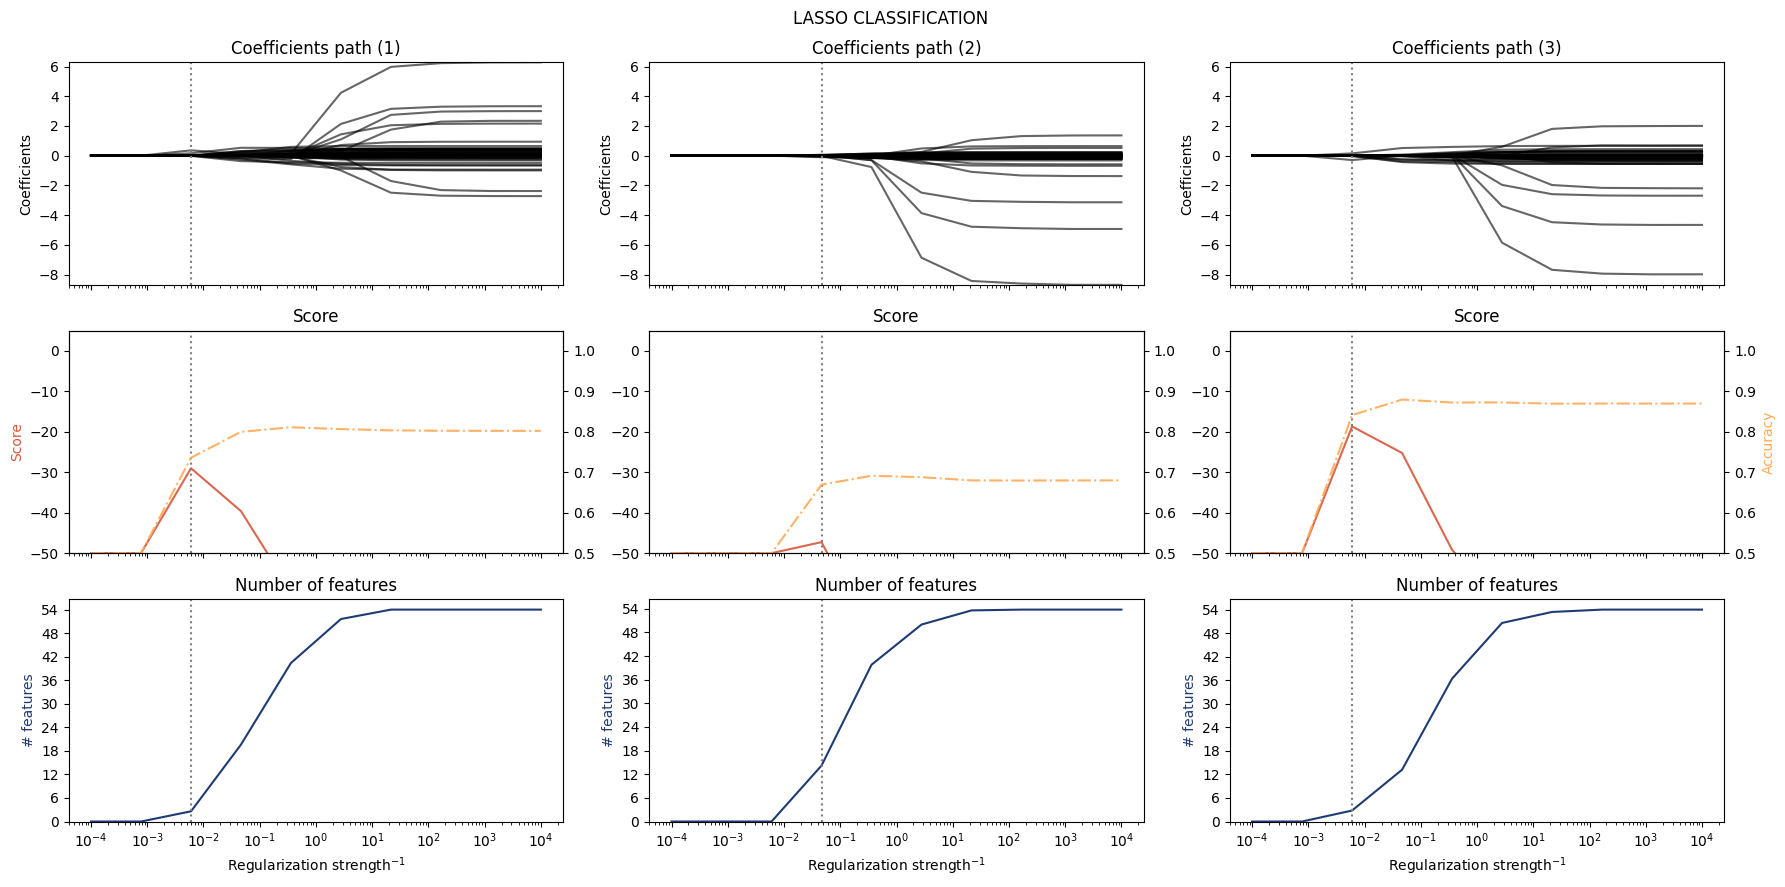

In [123]:
classifier, feats, coeffs = lasso_classification(dataset, Cs=10, plot=True)